# Introduction to Computer Vision - Project
Evangelos Ananiadis, 03409
Nikoleta Tsavlidou, 03578

## Description:
We created a lane detection algorithm, using the methods, as described in the article:      
<a href=https://www.sciencedirect.com/science/article/pii/S2214785320373302>
Advanced lane detection technique for structural highway based on computer vision algorithm</a>

The article describes the pipeline shown in the figure below.         
<img src="resources/lane_detection_pipeline.jpg" width="300">

| =================== |  
| Imports             |  
| =================== |

In [31]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

| =================== |  
| Parameters          |  
| =================== |

In [32]:
# Camera distortion parameters
# These parameters were extrated using
# https://github.com/yashdeep01/CameraCalibrationCheckerboard/tree/main
K = np.loadtxt('resources/mtx.csv', delimiter=',') # intrinsics 
D = np.loadtxt('resources/dist.csv', delimiter=',') # distortion coefficients

print(K.shape)  # must be (3, 3)
print(D.shape)  # usually (5,) or (1,5) or (8,)

# Crop ratios
top_ratio = 0.55
bottom_ratio = 0.7

# Bird's-eye-view parameters
src_perc = np.float32([
    (0.15, 0.9),   # bottom-left
    (0.9, 0.9),    # bottom-right
    (0.72, 0.10),  # top-right
    (0.6, 0.10)])  # top-left
dst_perc = np.float32([
    (0.20, 0.80),   # bottom-left
    (0.80, 0.80),   # bottom-right
    (0.80, 0.20),   # top-right
    (0.20, 0.20)    # top-left
])

(3, 3)
(5,)


| =================== |  
| Assistive Functions |  
| =================== |

In [33]:
def show_images_grid(images, cols=3, figsize=(12, 8), titles=None):
    """
    Display a list of images in a grid using subplots.

    Parameters:
        images (list): List of images (NumPy arrays in BGR or RGB format).
        cols (int): Number of columns in the grid.
        figsize (tuple): Figure size passed to matplotlib.
        titles (list or None): Optional list of titles for each image.
    """
    if not images:
        return

    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        # Convert BGR → RGB if coming from OpenCV
        if img.ndim == 3 and img.shape[2] == 3:
            img_display = img[:, :, ::1] if titles is None else img[:, :, ::1]
            img_display = img[:, :, ::-1]  # Convert BGR to RGB
        else:
            img_display = img

        plt.imshow(img_display, cmap='gray' if img.ndim == 2 else None)

        if titles and i < len(titles):
            plt.title(titles[i])

        plt.axis('off')

    plt.tight_layout()
    plt.show()


| ============================ |
| Image Manipulation Functions |
| ============================ | 

In [34]:
def calibrate_camera(img, K, D):
    '''
    Calibrate camera and undistort input image.
    Parameters:
    img (numpy.ndarray): Input image
    K, D: Intrinsics and distortion coefficients. Global parameters.
    w, h: image width and height
    
    Returns:
        numpy.ndarray: Cropped image.
    '''
    h, w = img.shape[:2]
    new_K, _ = cv2.getOptimalNewCameraMatrix(
    K, D, (w, h), alpha=1
    )
    undistorted = cv2.undistort(img, K, D, None, new_K)
    return undistorted

In [35]:
def crop_image_height(img, top_ratio=0.0, bottom_ratio=1.0):
    """
    Crop the image vertically using fractional ratios.
    
    Parameters:
        img (numpy.ndarray): Input BGR image.
        top_ratio (float): Fraction (0.0-1.0) from the top where the crop starts.
        bottom_ratio (float): Fraction (0.0-1.0) from the bottom where the crop ends.
    
    Returns:
        numpy.ndarray: Cropped image.
    """
    h, w = img.shape[:2]

    top = int(h * top_ratio)
    bottom = int(h * bottom_ratio)

    if top < 0 or bottom > h or top >= bottom:
        return img  # fallback if parameters invalid

    return img[top:bottom, :]

In [36]:
def apply_gaussian_blur(img, kernel_size=5):
    """
    Apply Gaussian Blur to an input image to reduce noise and smooth it.

    Parameters:
    img (np.ndarray): Input image
    kernel_size (int): Size of the Gaussian kernel. Must be a positive odd number.

    Returns:
        np.ndarray: Blurred image
    """
    # Ensure the kernel size is odd, as required by cv2.GaussianBlur
    if kernel_size % 2 == 0:
        kernel_size += 1
    
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [37]:
def convert_bgr_image_to_binary(img):
    """
    Convert an image to binary form using otsu thresholding.
    
    Parameters:
        img (numpy.ndarray): Input BGR image.
    Returns:
        numpy.ndarray: Binary image
    """
    _, binary = cv2.threshold(
            cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
            0,
            255,
            cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binary

In [38]:
def convert_bgr_image_to_gray(img):
    """
    Convert an image to gray.
    
    Parameters:
        img (numpy.ndarray): Input BGR image.
    Returns:
        numpy.ndarray: Gray image
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [39]:
def sobel_x_threshold(img, ksize=3, thresh_min=20, thresh_max=100):
    """
    Applies Sobel X gradient thresholding to a grayscale image.

    Parameters:
        img (np.ndarray): Grayscale input image.
        ksize (int): Kernel size of the Sobel operator (odd number: 3,5,7).
        thresh_min (int): Minimum absolute gradient value to accept.
        thresh_max (int): Maximum absolute gradient value to accept.

    Returns:
        np.ndarray: A binary image (0 or 1) where pixels meeting the
                    threshold criteria are marked as lane-like edges.
    """

    # Compute Sobel in X direction (horizontal derivative)
    sobel_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)

    # Convert gradient to absolute values
    abs_sobel_x = np.absolute(sobel_x)

    # Scale gradient to 8-bit range
    scaled = np.uint8(255 * abs_sobel_x / np.max(abs_sobel_x))

    # Apply threshold
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh_min) & (scaled <= thresh_max)] = 1

    return binary_output

In [40]:
def hls_lighting_threshold(image, thresh_min=0, thresh_max=255):
    """
    Apply thresholding on a selected HLS channel of an RGB image.

    Parameters:
    - image (np.ndarray) Input image in RGB format.
    - thresh_min (int): Minimum lighting value allowed in the threshold.
    - thresh_max (int): Maximum lighting value allowed in the threshold.

    Returns:
    - np.ndarray: A binary (0 or 1) image where pixels that fall within the threshold range are set to 1.
    """

    # Convert RGB image to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    # Extract the lightning channel
    ch_img = hls[:, :, 1]

    # Apply threshold to produce binary output
    binary_output = np.zeros_like(ch_img)
    binary_output[(ch_img >= thresh_min) & (ch_img <= thresh_max)] = 1

    return binary_output

In [41]:
def combine_thresholds(sobel_image, hls_image):
    """
    Combine the two images

    Parameters:
    - sobel_image (np.ndarray): Input sobel image.
    - hls_image (np.ndarray): Input hls image.

    Returns:
    - np.ndarray: The combined image
    """
    combined_img = np.zeros_like(sobel_image)
    combined_img[(hls_img == 1) | (sobel_image == 1)] = 1
    return combined_img

In [42]:
def create_polygon(img, src_perc):
    img_h, img_w = img.shape[:2]
    pixel_points = np.zeros_like(src_perc)
    pixel_points[:, 0] = src_perc[:, 0] * img_w
    pixel_points[:, 1] = src_perc[:, 1] * img_h
    # Close the polygon by appending the first point
    pixel_points = np.vstack([pixel_points, pixel_points[0]])
    return pixel_points

In [43]:
def birds_eye_view(image, src_perc, dst_perc):
    """
    Generate a bird's-eye-view (top-down) perspective transform of an input image
    using percentage-based source and destination coordinates. The output image
    size is computed automatically based on the destination percentage layout.

    Parameters:
    - image (np.ndarray): Input image in RGB format.
    - src_perc (np.ndarray): Four (x_percent, y_percent) points defining the
                              trapezoid region in the original image.
    - dst_perc (np.ndarray): Four (x_percent, y_percent) points defining the
                              rectangular region in the warped output image.

    Returns:
    - np.ndarray: The transformed image in bird's-eye view perspective with
                  dimensions derived from destination-percent coordinates.
    """

    h, w = image.shape[:2]

    # Convert percentage-based points -> pixel coordinates for source
    src_points = np.float32([[x * w, y * h] for (x, y) in src_perc])

    # Convert destination % -> output pixel coordinates
    dst_points = np.float32([[x * w, y * h] for (x, y) in dst_perc])


    # Compute perspective transform
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)

    # Warp using automatically determined output resolution
    warped = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)

    return warped

In [44]:
def sliding_window_lane_detection(
    binary_warped,
    nwindows=9,
    margin=100,
    minpix=50
):
    """
    Perform sliding window lane detection on a binary bird's-eye image.

    Parameters:
    - binary_warped (np.ndarray): Binary (0/1 or 0/255) bird's-eye-view image
    - nwindows (int): Number of sliding windows
    - margin (int): Half-width of each window
    - minpix (int): Minimum pixels required to recentre window

    Returns:
    - left_fit (np.ndarray): Polynomial coefficients for left lane
    - right_fit (np.ndarray): Polynomial coefficients for right lane
    - out_img (np.ndarray): Visualization image
    """

    # Ensure binary format
    binary = (binary_warped > 0).astype(np.uint8)

    h, w = binary.shape

    # Histogram of bottom half
    histogram = np.sum(binary[h // 2 :, :], axis=0)

    # Find base points
    midpoint = w // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set window height
    window_height = h // nwindows

    # Identify all non-zero pixels
    nonzero_y, nonzero_x = binary.nonzero()

    # Current positions
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    # Visualization image
    out_img = np.dstack((binary * 255, binary * 255, binary * 255))

    for window in range(nwindows):
        win_y_low = h - (window + 1) * window_height
        win_y_high = h - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw windows
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (255, 0, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 0, 255), 2)

        # Identify pixels within windows
        good_left_inds = (
            (nonzero_y >= win_y_low) & (nonzero_y < win_y_high) &
            (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)
        ).nonzero()[0]

        good_right_inds = (
            (nonzero_y >= win_y_low) & (nonzero_y < win_y_high) &
            (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)
        ).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # Recenter windows
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds]
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds]

    # Fit second-order polynomials
    left_fit = np.polyfit(lefty, leftx, 2) if len(leftx) else None
    right_fit = np.polyfit(righty, rightx, 2) if len(rightx) else None

    # Color detected pixels
    out_img[lefty, leftx] = [255, 255, 0]
    out_img[righty, rightx] = [0, 255, 255]

    return left_fit, right_fit, out_img


In [45]:
def illustrate_lane_space(
    binary_warped,
    left_fit,
    right_fit
):
    """
    Generate a shape from the polynomials that sliding window search returned.

    Parameters:
    - binary_warped (np.ndarray): Binary (0/1 or 0/255) bird's-eye-view image
    - left_fit (np.ndarray): Polynomial coefficients for left lane
    - right_fit (np.ndarray): Polynomial coefficients for right lane

    Returns:
    - out_img (np.ndarray): Illustrated lane space
    """

    h, w = binary_warped.shape[:2]

    # Create blank RGB image
    out_img = np.zeros((h, w, 3), dtype=np.uint8)

    # Generate y-values
    ploty = np.linspace(0, h - 1, h)

    # Evaluate polynomials
    leftx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    rightx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    # Stack points for polygon
    left_pts = np.vstack([leftx, ploty]).T
    right_pts = np.vstack([rightx, ploty]).T[::-1]

    lane_pts = np.vstack([left_pts, right_pts]).astype(np.int32)

    # Fill lane area
    cv2.fillPoly(out_img, [lane_pts], (0, 255, 0))
    return convert_bgr_image_to_gray(out_img)


In [46]:
def reverse_birds_eye_view(image, src_perc, dst_perc):
    """
    Reverse the bird's-eye-view (top-down) perspective 

    Parameters:
    - image (np.ndarray): Input image in RGB format.
    - src_perc (np.ndarray): Four (x_percent, y_percent) points defining the
                              trapezoid region in the original image.
    - dst_perc (np.ndarray): Four (x_percent, y_percent) points defining the
                              rectangular region in the warped output image.

    Returns:
    - np.ndarray: The transformed image in normal perspective with
                  dimensions derived from destination-percent coordinates.
    """

    h, w = image.shape[:2]

    # Convert percentage-based points -> pixel coordinates for source
    src_points = np.float32([[x * w, y * h] for (x, y) in src_perc])

    # Convert destination % -> output pixel coordinates
    dst_points = np.float32([[x * w, y * h] for (x, y) in dst_perc])

    # Compute perspective transform
    matrix = cv2.getPerspectiveTransform(dst_points, src_points)

    # Warp using automatically determined output resolution
    unwarped = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)

    return unwarped

In [47]:
def uncrop_image_height(img, original_shape, top_ratio=0.0, bottom_ratio=1.0):
    """
    Create zeros at the shape of the original image, and position
    the cropped image on top, where it was cropped from.
    
    Parameters:
        img (numpy.ndarray): Input BGR image.
        top_ratio (float): Fraction (0.0-1.0) from the top where the crop starts.
        bottom_ratio (float): Fraction (0.0-1.0) from the bottom where the crop ends.
    
    Returns:
        numpy.ndarray: Zeros with the overlaid image.
    """
    h, w, c = original_shape
    out_img = np.zeros((h, w, c), dtype=img.dtype)
    top = int(h * top_ratio)
    bottom = int(h * bottom_ratio)

    out_img[top:bottom, :, :] = img
    return out_img

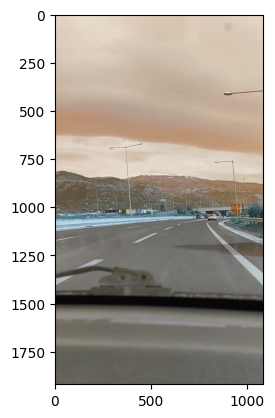

In [48]:
# Image test - Step-by-step
img = cv2.imread("test_images/test2.jpg")
plt.imshow(img)

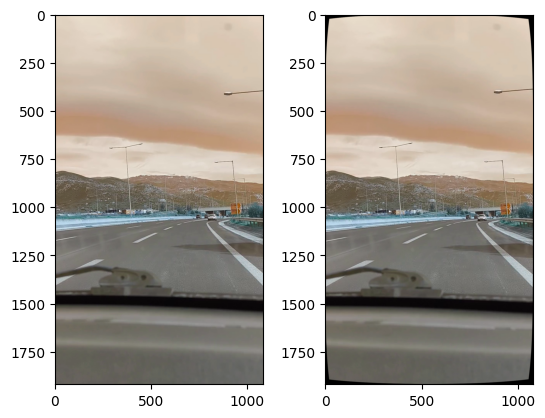

In [49]:
# Undistort 
undistorted_img = calibrate_camera(img, K, D)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(undistorted_img)

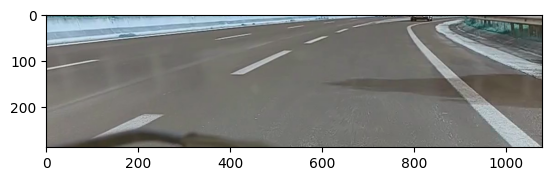

In [50]:
# and Crop original image
cropped_img = crop_image_height(img, top_ratio=0.55, bottom_ratio=0.7)
plt.imshow(cropped_img)

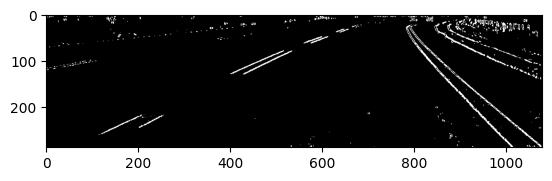

In [51]:
# Apply Sobel Thresholding
gray_img = convert_bgr_image_to_gray(cropped_img)
blurred_img_gray = apply_gaussian_blur(gray_img)
sobel_img = sobel_x_threshold(blurred_img_gray, thresh_min=25, thresh_max=75)
plt.imshow(sobel_img, cmap="gray")

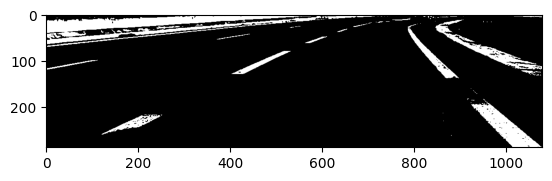

In [52]:
# Apply HLS-Thresholding
hls_img = hls_lighting_threshold(cropped_img, thresh_min=170, thresh_max=255) 
plt.imshow(hls_img, cmap="gray")

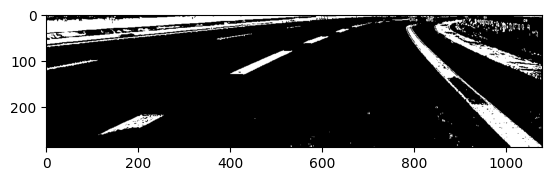

In [53]:
# Combine transformations
combined_img = combine_thresholds(sobel_img, cropped_img)
plt.imshow(combined_img, cmap="gray")

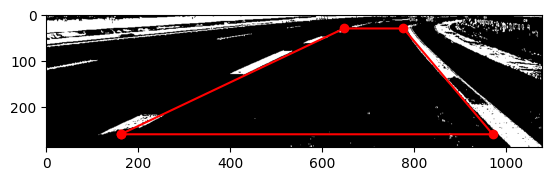

In [54]:
polygon_points = create_polygon(combined_img, src_perc)

# Plot images 
plt.imshow(combined_img, cmap="gray")
plt.plot(polygon_points[:, 0],  polygon_points[:, 1], '-or')
plt.axis("on")
plt.show()

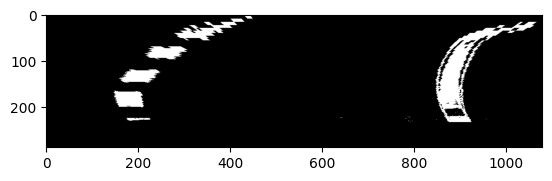

In [55]:
# Warp image to bird's eye view
birds_eye_image = birds_eye_view(combined_img, src_perc, dst_perc)
plt.subplot(2, 1, 2)
plt.imshow(birds_eye_image, cmap="gray")

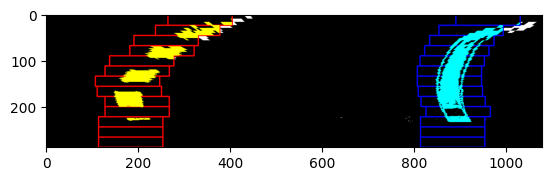

In [56]:
# Run sliding window detection
left_fit, right_fit, debug_img = sliding_window_lane_detection(
    birds_eye_image,
    nwindows=13,
    margin=70,
    minpix=70
)


# Visualize
plt.imshow(debug_img)


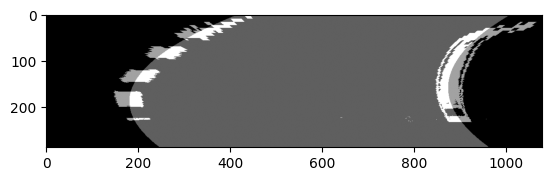

In [57]:
lane_space = illustrate_lane_space(birds_eye_image, left_fit, right_fit)
illustrated_img = cv2.addWeighted((birds_eye_image*255).astype(np.uint8), 0.5, lane_space, 0.5, 0)
plt.imshow(illustrated_img, cmap="gray")


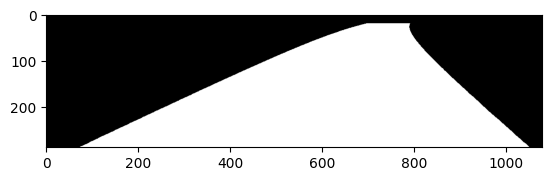

In [58]:
unwarped_lane_space = reverse_birds_eye_view(lane_space, src_perc, dst_perc)
plt.imshow(unwarped_lane_space, cmap="gray")

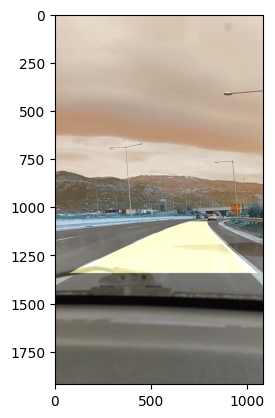

In [59]:
unwarped_lane_space_bgr = cv2.cvtColor(unwarped_lane_space, cv2.COLOR_GRAY2BGR)
uncropped_lane_space = uncrop_image_height(unwarped_lane_space_bgr, img.shape, top_ratio=top_ratio, bottom_ratio=bottom_ratio)
uncropped_lane_space[:,:,2] = uncropped_lane_space[:,:,2] * 255 # Make detected lane space red

detected_lane_space = cv2.addWeighted(img.astype(np.uint8), 1.0, uncropped_lane_space.astype(np.uint8), 1.0, 0)
plt.imshow(detected_lane_space)